In [1]:
import matplotlib.pyplot as plt
import numpy as np
from orbsim.r3b_2d.analyticals import *
from orbsim.r3b_2d.simulators import launch_sim
from orbsim.plotting import orbitplot2d, orbitplot_non_inertial
from orbsim import *
from orbsim.r3b_2d import *
import operator

In [2]:
N=4
psis=[]
paths=[]
examples=[
#          ["hohmann", [-2.086814820119193, -0.000122173047640, 3.111181716545691],5],
         ["long_leto",[3.794182930145708, 0.023901745288554, 3.090702702702703],200],
#          ["short_leto",[-0.138042744751570, -0.144259374836607, 3.127288444444444],41],
#          ["3-day_hohmann",[-2.272183066647597, -0.075821466029764, 3.135519748743719],3],
#          ["1-day_hohmann",[-2.277654673852600, 0.047996554429844, 3.810000000000000],1]
]#[title, psi, duration]
for title, psi, duration in examples:
    for i in range(N):
        permute_psi = np.array(psi)+np.array([i*1e-4,i*1e-4,i*1e-4])
        path = launch_sim(permute_psi, max_iter=1e7, duration=duration)
        psis.append(permute_psi)
        paths.append(path) 


1e-09
1e-09
1e-09
1e-09


In [5]:
N=5
psi=[0.,0.,3.05]
psis=[]
paths=[]
title=None
for i in range(N):
    permute_psi = np.array(psi)+np.array([0.,i*2*pi/N,0.])
    path = launch_sim(permute_psi, max_iter=1e7, duration=4)
    psis.append(permute_psi)
    paths.append(path) 

1e-09
1e-09
1e-09
.
1e-09
.
1e-09


In [4]:
lyaps=[]
for a in range(N):
    for b in range(N):
        print(f"comparing {a} and {b}")
        if a>=b:
            continue
        lyap=[]
        _a=np.array(paths[a][1]).T
        _b=np.array(paths[b][1]).T
        xas=_a[0]
        yas=_a[1]
        xbs=_b[0]
        ybs=_b[1]
#         hs=(_a[4],_b[4])
        ts=(_a[5],_b[5])
        print(f"length of the trajectory coordinate arrays: {a}: {len(xas)}, {b}: {len(xbs)}")
        
#         ts=[None,None]
#         for l in range(len(hs)):
#             idxs=[]
#             tally=0
#             for i in range(len(hs[l])): # each time step h, check whether the little tally has reached our threshold.
#                 h=hs[l][i]              # if it has, take that index as a time step
#                 tally+=h
#                 if tally>=1.5e-5:
#                     idxs.append(i)
#                     tally=0
#             ts[l] = idxs
            
        _,min_ts = min([(len(x), list(x)) for x in ts])
        print(f"time steps standardized: comparing at {len(min_ts)} points on the trajectory. Last point will be at {max(min_ts)}")
        for idx in range(len(min_ts)):
#             idx=min_ts[i]
            lyap.append(sqrt((xas[idx]-xbs[idx])**2+(yas[idx]-ybs[idx])**2))
        lyaps.append(lyap)
print(len(lyaps))

comparing 0 and 0
comparing 0 and 1
length of the trajectory coordinate arrays: 0: 5035020, 1: 5199470
time steps standardized: comparing at 5035020 points on the trajectory. Last point will be at 45.99363908707698
comparing 0 and 2
length of the trajectory coordinate arrays: 0: 5035020, 2: 5021559
time steps standardized: comparing at 5021559 points on the trajectory. Last point will be at 45.99362959514798
comparing 0 and 3
length of the trajectory coordinate arrays: 0: 5035020, 3: 5704090
time steps standardized: comparing at 5035020 points on the trajectory. Last point will be at 45.99363908707698
comparing 1 and 0
comparing 1 and 1
comparing 1 and 2
length of the trajectory coordinate arrays: 1: 5199470, 2: 5021559
time steps standardized: comparing at 5021559 points on the trajectory. Last point will be at 45.99362959514798
comparing 1 and 3
length of the trajectory coordinate arrays: 1: 5199470, 3: 5704090
time steps standardized: comparing at 5199470 points on the trajectory. L

In [5]:
loglyaps=[]
for i in range(len(lyaps)):
    lyap=lyaps[i][1:]
    loglyap=[np.log(x) for x in lyap]
    loglyaps.append(loglyap)

In [6]:
def find_segments(lyap):
    segments=[]
    prev_l = -1e8
    rising = True
    segment=[0]
    for i,l in enumerate(lyap):
        if rising:
            if l<prev_l:
                rising = False
                segment.append(i)
        else:
            if l>prev_l:
                rising = True
                segments.append(segment)
                segment=[i]
        prev_l = l
    if len(segment) == 1:
        segment.append(len(lyap))
    segments.append(segment)
    return segments

In [7]:
from scipy import stats
def compute_slope(lyap, filepath=".", title="derp"):
    segments=find_segments(lyap)
    plt.plot(range(len(lyap)),lyap,color='grey',alpha=0.5)
    slopes=[]
    for lb, ub in [[int(x),int(y)] for [x,y] in segments]:
        if ub-lb < 100:
            continue
        if ub>len(lyap):
            break
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(lb,ub),lyap[lb:ub])
        slopes.append(slope)
        #print(slope, intercept)
        line=slope*range(lb,ub)+intercept
        plt.plot([lb,ub],[line[0],line[-1]],color='darkred')
        plt.plot(range(lb,ub),lyap[lb:ub],color='teal')
    mean_slope = np.mean(slopes)
    plt.suptitle(f"mean slope = {mean_slope}")
    plt.savefig(f"{filepath}/{title}.pdf")
    plt.clf()
    return mean_slope

In [8]:
slopes=[]
for i, loglyap in enumerate(loglyaps):
    slopes.append(compute_slope(loglyap,filepath="lyapunov_figs/slopes",title=f"{title}_{i}"))
print(f"mean slope = {np.mean(slopes)}")
    

mean slope = 4.761982642353445e-05


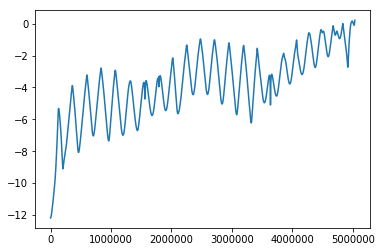

In [9]:
lyap=lyaps[2][1:]
loglyap=[np.log(x) for x in lyap]
plt.plot(range(len(loglyap)),loglyap)

In [100]:
slope, intercept, r_value, p_value, std_err = stats.linregress(range(lb,ub),loglyap[lb:ub])
print(slope, intercept)

3.040160021068095e-06 -4.150509459758794


In [75]:
line=slope*range(lb,ub)+intercept

In [31]:
hs = np.array(paths[0][1]).T[4]

In [32]:
min(hs)

6.778256920031252e-08

In [33]:
max(hs)

5.798294330541472e-05

In [36]:
np.std(hs)

1.0882626399622566e-05

In [38]:
np.mean(hs)

7.04610385050155e-06

In [39]:
np.median(hs)

1.4170823204431882e-06

In [11]:
for i,lyap in enumerate(lyaps):
    print(i)
    print(f"max_dist={max(lyap)}\nmin_dist={min(lyap[1:])}\nmean_dist={np.mean(lyap)}\n")

0
max_dist=0.22066456080414681
min_dist=1.698076267163853e-06
mean_dist=0.03069008199027767

1
max_dist=0.3361942995790322
min_dist=3.396153190746294e-06
mean_dist=0.052128642235248865

2
max_dist=0.46263197877697293
min_dist=5.094228851045785e-06
mean_dist=0.05862640789126122

3
max_dist=0.18417964934186015
min_dist=1.6980765870977226e-06
mean_dist=0.022360363891778628

4
max_dist=0.3523035474515596
min_dist=3.3961522611417697e-06
mean_dist=0.0408686303133852

5
max_dist=0.2224322258850193
min_dist=1.6980753888654565e-06
mean_dist=0.029016250363473158



# Experiments

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [165]:
nIndividuals=5
nJitter=60
init_sigma = 0.01  # jitter spread
init_alpha = 0.03  # learningrate
psis = np.array([[float(x),float(x),float(x)] for x in range(nIndividuals)])

sigma = np.ones(nIndividuals) * init_sigma
alpha = np.ones(nIndividuals) * init_alpha
jitter = np.ones((nIndividuals, nJitter, 3))
jitter = np.array([sigma[idx] * jitt for idx, jitt in enumerate(jitter)])
jitter= jitter.reshape(nJitter,nIndividuals,3)
jitter[0] *= 0  # Make sure all set individual psis are evaluated without jitter
points = jitter + psis
# jitter = [sigma[idx] * jitt for idx, jitt in enumerate(jitter)]
points = points.reshape(nIndividuals * nJitter, 3)
for i, pt in enumerate(points):
    points[i] = ensure_bounds(pt)
points = points.reshape(nJitter, nIndividuals, 3)
successes = np.zeros(nIndividuals * nJitter, dtype=bool)
scores = np.zeros(nIndividuals * nJitter)

In [125]:
psi_scores = scores.T[0]
print(psi_scores)
for idx, score in enumerate(psi_scores):
    new_sigma=init_sigma * score
    new_alpha=init_alpha * score
    sigma[idx] = new_sigma
    alpha[idx] = new_alpha
    
psis += steps

[400. 400. 400. 400. 400.]


In [126]:
x=np.array([np.array(x).shape for x in [steps,psi_scores,psis]])
print(x)

[(5, 3) (5,) (5, 3)]


In [127]:
np.dot(np.array(range(nJitter)),jitter[4])

array([9.80360333, 9.79722506, 9.67811714])

In [168]:
x=4
print(psis)
print(psis[x],psis.shape)
print(points[x],points.shape)
print(jitter[x],jitter.shape)
print(scores[x],scores.shape)
print(steps[x],steps.shape)

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 4.]]
[4. 4. 4.] (5, 3)
[[1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 4.]
 [5. 5. 5.]] (60, 5, 3)
[[0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0.01 0.01 0.01]
 [0

In [129]:
points.shape

(60, 5, 3)

In [170]:
success=[True,False,True,False,False,True]
indi = 3
jit=2
score = np.array([1,1,2,2,3,3])
psis=[[1,1,1],[2,2,2],[3,3,3]]
points=np.ones((jit,indi,3))+np.array(psis)
points=points.reshape(indi*jit,3)
winners = []
# for idx,succ in enumerate(success):
#     if succ:
#         winners.append(points.idx)
winners=[points[idx] for idx,succ in enumerate(success) if succ]

In [171]:
sco=score.reshape(indi,jit)
# sco-=sco.mean()
# sco/=sco.std()
sco=sco-sco.mean()
sco=sco/sco.std()
sco

array([[-1.22474487, -1.22474487],
       [ 0.        ,  0.        ],
       [ 1.22474487,  1.22474487]])

In [172]:
points.reshape(indi*jit,3)

array([[2., 2., 2.],
       [3., 3., 3.],
       [4., 4., 4.],
       [2., 2., 2.],
       [3., 3., 3.],
       [4., 4., 4.]])

In [173]:
xpoints = points.reshape(indi*jit,3)
for i,pt in enumerate(xpoints):
    xpoints[i]=ensure_bounds(pt)

In [174]:
xpoints

array([[ 2.        , -1.14159265,  3.        ],
       [ 3.        , -0.14159265,  3.        ],
       [ 4.        , -2.28318531,  3.8       ],
       [ 2.        , -1.14159265,  3.        ],
       [ 3.        , -0.14159265,  3.        ],
       [ 4.        , -2.28318531,  3.8       ]])

In [175]:
sco=np.array(score).reshape((indi,jit))

In [176]:
np.dot(sco[0],np.ones((indi,jit,3))[0])*5

array([10., 10., 10.])

In [95]:
np.ones((3,3,3))

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [119]:
indi, jit

(3, 2)

In [118]:
score

[1, 1, 1, 2, 2, 2]

In [106]:
score

[1, 1, 1, 2, 2, 2, 3, 3, 3]

In [166]:
points

array([[[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5.,

In [78]:
@njit
def ensure_bounds(pt):
    pos,ang,burn=pt
    lb, ub = ([0, -pi, 3], [2 * pi, 0, 3.8])
    return [np.mod(pos,ub[0]-lb[0]),np.mod(ang,lb[1]),max(lb[2],min(ub[2],burn))]

In [79]:
%timeit ensure_bounds([9,9,9])

The slowest run took 4.76 times longer than the fastest. This could mean that an intermediate result is being cached.
19.7 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
